In [1]:
#Code written by Mark Jayson Cortez for MATH6397.

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import seaborn as sns
import pandas as pd

#  Item 1. Fokker-plack equation

In [2]:
def ode(u,R,tau,I):
    return (-u+R*I)/tau

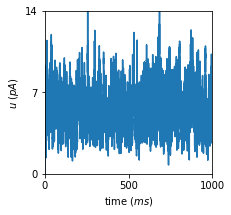

In [3]:
T=1000
R=500
del_u=1
tau=1
I=0
u=[0]
t=[0] 
i=0
h=0.01
l=5
while t[i]<T:
    t=np.append(t,[t[i]+h])
    if np.random.uniform(0,1,1)<l*h:
        u=np.append(u,u[i]+del_u)
    else:
        u=np.append(u,[u[i]+h*ode(u[i],R,tau,I)])     
    i+=1
f=plt.figure(figsize=(3,3))
plt.plot(t,u)
plt.xlabel(r'time ($ms$)')
plt.ylabel(r'$u$ $(pA)$')
plt.xlim([0,T])
plt.xticks([0,500,T])
plt.ylim([0,14])
plt.yticks([0,7,14])
f.savefig('wothresh.png', format='png', dpi=500,bbox_inches="tight")

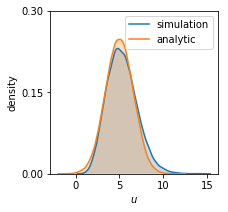

In [4]:
time=10000
f=plt.figure(figsize=(3,3))
sns.kdeplot(np.random.choice(u[time:],size=100000),shade=True,label='simulation')
sns.kdeplot(np.random.normal(tau*l*del_u,np.sqrt(tau*l*del_u**2)/np.sqrt(2),size=100000),shade=True,label='analytic')
plt.xlabel(r'$u$')
plt.ylabel('density')
plt.yticks([0,0.15,0.3])
plt.legend(loc='upper right')
f.savefig('gaussian.png', format='png', dpi=500,bbox_inches="tight")

# 2. First passage time

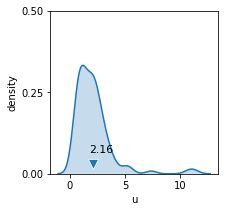

In [7]:
u_rest=0
R=500
I=0
del_u=1
tau=1
thresh=5

h=0.001
l=5

rec_time=[]
repeat=100
for j in range(repeat):
    i=0
    rep=True
    t=[0] 
    u=[u_rest]
    while rep==True:
        t=np.append(t,[t[i]+h])
        if np.random.uniform(0,1,1)<l*h:
            u=np.append(u,u[i]+del_u)
        else:
            u=np.append(u,[u[i]+h*ode(u[i],R,tau,I)])
        if u[i+1]>thresh:
            u[i+1]=u_rest
            rec_time.append(t[i]+h)
            #print(rec_time[-1])
            rep=False
        i=i+1
f=plt.figure(figsize=(3,3))
sns.kdeplot(rec_time,shade=True)
sns.scatterplot([np.mean(rec_time)],[0.03],marker='v',s=100,color='C0')
plt.text(np.mean(rec_time)-0.4,0.065, '%2.2f' %np.mean(rec_time) , fontsize=11,color='k')
plt.xlabel('u')
plt.ylabel('density')
plt.ylim([0,0.5])
plt.yticks([0,0.25,0.5])
f.savefig('mean_passage.png', format='png', dpi=500,bbox_inches="tight")

# 3. Erlang distribution

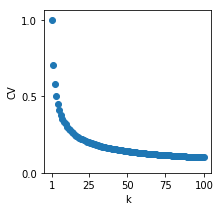

In [8]:
N=100
CV=np.zeros(N)
for i in range(N):
    CV[i]=1/np.sqrt(i+1)
f=plt.figure(figsize=(3,3))
plt.scatter(range(1,N+1),CV)
plt.xticks([1,25,50,75,100])
plt.yticks([0,0.5,1])
plt.xlabel('k')
plt.ylabel('CV')
f.savefig('CV.png', format='png', dpi=500,bbox_inches="tight")

# 5. 2-step adaptation

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
@jit(nopython=True, parallel=True)
def prob(N,n1,n2,n3,u):
    P=np.zeros(7)
    P[0]=(1-u)*(n1/N)*(n2/N)
    P[1]=(1-u)*(n1/N)*(n3/N)   #wont matter
    P[2]=(1-u)*(n2/N)*(n1/N)+u*(n1/N)*(n1/N)
    P[3]=(n3/N)*(n1/N)   #wont matter
    P[4]=(1-u)*(n2/N)*(n3/N)   #wont matter
    P[5]=(n3/N)*(n2/N)+u*(n2/N)*(n2/N)
    P[6]=1-(P[0]+P[1]+P[2]+P[3]+P[4]+P[5])
    return P

@jit(nopython=True, parallel=True)
def simulate(N,u):
    n1=[N]
    n2=[0]
    n3=[0]
    i=0
    while n3[i]<1:
        P=prob(N,n1[i],n2[i],n3[i],u)
        P_sum=np.cumsum(P)
        epsilon=np.random.uniform(0,1)
        if epsilon<P_sum[0]:
            n1.append(n1[i]+1)
            n2.append(n2[i]-1)
            n3.append(n3[i])
        elif epsilon<P_sum[1]:
            n1.append(n1[i]+1)
            n2.append(n2[i])
            n3.append(n3[i]-1)
        elif epsilon<P_sum[2]:
            n1.append(n1[i]-1)
            n2.append(n2[i]+1)
            n3.append(n3[i])
        elif epsilon<P_sum[3]:
            n1.append(n1[i]-1)
            n2.append(n2[i])
            n3.append(n3[i]+1)
        elif epsilon<P_sum[4]:
            n1.append(n1[i])
            n2.append(n2[i]+1)
            n3.append(n3[i]-1)
        elif epsilon<P_sum[5]:
            n1.append(n1[i])
            n2.append(n2[i]-1)
            n3.append(n3[i]+1)
        else:
            n1.append(n1[i])
            n2.append(n2[i])
            n3.append(n3[i])
        i+=1   
    return n1,n2,n3,i     

In [ ]:
N=1000
scale=[0.1,1,10]
repeats=50
t_rec=np.zeros([repeats,len(scale)])
for j in range(repeats):
    for i in range(len(scale)):
        n1,n2,n3,t=simulate(N,scale[i]/N)
        t_rec[j,i]=t
columns=' '
np.savetxt("time.csv", t_rec, delimiter=",",header=columns)

In [ ]:
N=10
scale=0.0001
repeats=100
t_rec=np.zeros(repeats)
for j in range(repeats):
    n1,n2,n3,t=simulate(N,scale/N)
    t_rec[j]=t
    print(t)

In [ ]:
time1=pd.read_csv("time1.csv").values
time2=pd.read_csv("time2.csv").values
time3=pd.read_csv("time2.csv").values
time=np.concatenate((time1,time2,time3),axis=0)

In [ ]:
scale=[0.1,1,10]
N=1000
f,axes=plt.subplots(1,3,figsize=(8,3))
y_pos=[0.1*1e-7,0.0000002,0.0000025]
text_pos=[0.1*1e-7*2.2,0.0000002*2.2,0.0000025*2.2]
for i in range(3):
    sns.kdeplot(time[:,i],shade=True,ax=axes[i])
    sns.scatterplot([np.mean(time[:,i])],y_pos[i],marker='v',s=100,color='C0',ax=axes[i],label='mean')
    axes[i].text(np.mean(time[:,i]),text_pos[i], '%2.2f' %np.mean(time[:,i]) , fontsize=11,color='k')
    axes[i].set_xlabel('time')
    axes[i].set_title(r'$\mu =\dfrac{%2.2f}{1000}$' %(scale[i]),y=1.2)
axes[0].set_ylabel('density')
plt.tight_layout(w_pad=1) 
f.savefig('adapt_time.png', format='png', dpi=500,bbox_inches="tight")